In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

In [13]:
'''
transforms.Compose

主要作用是串联多个图片变换的操作

transforms.Normalize

前面的（0.5，0.5，0.5） 是 R G B 三个通道上的均值， 后面(0.5, 0.5, 0.5)是三个通道的标准差
Normalize对每个通道执行以下操作：image =（图像-平均值）/ std
在当前情况下，参数mean，std分别以0.5和0.5的形式传递。这将使图像在[-1,1]范围内归一化
例如，最小值0将转换为（0-0.5）/0.5=-1，最大值1将转换为1

'''
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


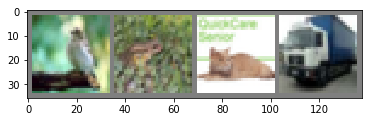

 bird  frog   cat truck


In [23]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        '''
        1 input image channel,
        6 output channels, 
        5x5 square convolution 
        '''
        
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # an affine operation: y = Wx + b
        
        '''
        nn.Linear(in_features, out_features, bias=True)
        in_features指的是输入的二维张量的大小，即输入的[batch_size, size]中的size。
        out_features指的是输出的二维张量的大小，即输出的二维张量的形状为[batch_size，output_size]，
        当然，它也代表了该全连接层的神经元个数。
        '''
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [25]:
import torch.optim as optim

'''
定义一个损失函数和优化器
使用分类交叉熵Cross-Entropy 作损失函数
使用动量SGD做优化器。
'''

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [26]:
# loop over the dataset multiple times
for epoch in range(2):
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Does the update
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        # print every 2000 mini-batches
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.138
[1,  4000] loss: 1.833
[1,  6000] loss: 1.642
[1,  8000] loss: 1.533
[1, 10000] loss: 1.483
[1, 12000] loss: 1.444
[2,  2000] loss: 1.369
[2,  4000] loss: 1.339
[2,  6000] loss: 1.305
[2,  8000] loss: 1.298
[2, 10000] loss: 1.300
[2, 12000] loss: 1.277
Finished Training


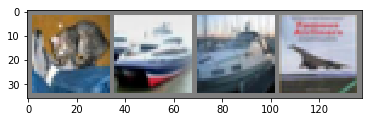

GroundTruth:    cat  ship  ship plane


In [34]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [35]:
outputs = net(images)

In [36]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog  ship plane  ship


In [37]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [53]:
class_correct = list(0 for i in range(10))
class_total = list(0 for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        # 0列最大值, 1行最大值
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 71 %
Accuracy of  bird : 31 %
Accuracy of   cat : 12 %
Accuracy of  deer : 47 %
Accuracy of   dog : 60 %
Accuracy of  frog : 69 %
Accuracy of horse : 63 %
Accuracy of  ship : 71 %
Accuracy of truck : 62 %
